In [1]:
import sys
import os

sys.path.append(os.path.abspath('..'))

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score

from tqdm import tqdm

from math import sqrt

In [3]:
from NN_utils.NeuralNetwork import NeuralNetwork
from NN_utils.Layers.RNN import RNN
from NN_utils.Layers.LSTM import LSTM
from NN_utils.Layers.GRU import GRU

from NN_utils.Losses.MSE import MSE

In [4]:
plt.rcParams["figure.figsize"] = (20, 6)

seed = 21
rng = np.random.default_rng(seed)

# Dataset

URL: https://archive.ics.uci.edu/dataset/851/steel+industry+energy+consumption

This dataset describes the electricity consumption of DAEWOO Steel Co. Ltd in South Korea.

1. date
2. Usage_kWh – Industry Energy Consumption (target)
3. Lagging_Current_Reactive.Power_kVarh
4. Leading_Current_Reactive_Power_kVarh
5. CO2(tCO2): ppm
6. Lagging_Current_Power_Factor
7. Leading_Current_Power_Factor
8. NSM: Number of Seconds from midnight
9. WeekStatus : Weekend (0) or a Weekday(1)
10. Day_of_week: Sunday, Monday, ..., Saturday
11. Load_Type : Light Load, Medium Load, Maximum Load

# Exploratory data analysis

In [5]:
data = pd.read_csv('../data/steel_industry_data', parse_dates=['date'], index_col=['date'])

In [6]:
data.head()

,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus,Day_of_week,Load_Type
date,,,,,,,,,,
2018-01-01 00:15:00,3.17,2.95,0.0,0.0,73.21,100.0,900,Weekday,Monday,Light_Load
2018-01-01 00:30:00,4.00,4.46,0.0,0.0,66.77,100.0,1800,Weekday,Monday,Light_Load
2018-01-01 00:45:00,3.24,3.28,0.0,0.0,70.28,100.0,2700,Weekday,Monday,Light_Load
2018-01-01 01:00:00,3.31,3.56,0.0,0.0,68.09,100.0,3600,Weekday,Monday,Light_Load
2018-01-01 01:15:00,3.82,4.50,0.0,0.0,64.72,100.0,4500,Weekday,Monday,Light_Load


In [7]:
data.shape

(35040, 10)

No missing values

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 35040 entries, 2018-01-01 00:15:00 to 2018-12-31 00:00:00
Data columns (total 10 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Usage_kWh                             35040 non-null  float64
 1   Lagging_Current_Reactive.Power_kVarh  35040 non-null  float64
 2   Leading_Current_Reactive_Power_kVarh  35040 non-null  float64
 3   CO2(tCO2)                             35040 non-null  float64
 4   Lagging_Current_Power_Factor          35040 non-null  float64
 5   Leading_Current_Power_Factor          35040 non-null  float64
 6   NSM                                   35040 non-null  int64  
 7   WeekStatus                            35040 non-null  object 
 8   Day_of_week                           35040 non-null  object 
 9   Load_Type                             35040 non-null  object 
dtypes: float64(6), int64(1), object(3)
memory usage

In [9]:
data.describe()

,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM
count,35040.000000,35040.000000,35040.000000,35040.000000,35040.000000,35040.000000,35040.000000
mean,27.386892,13.035384,3.870949,0.011524,80.578056,84.367870,42750.000000
std,33.444380,16.306000,7.424463,0.016151,18.921322,30.456535,24940.534317
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.200000,2.300000,0.000000,0.000000,63.320000,99.700000,21375.000000
50%,4.570000,5.000000,0.000000,0.000000,87.960000,100.000000,42750.000000
75%,51.237500,22.640000,2.090000,0.020000,99.022500,100.000000,64125.000000
max,157.180000,96.910000,27.760000,0.070000,100.000000,100.000000,85500.000000


In [10]:
numeric_columns = ['Lagging_Current_Reactive.Power_kVarh',
                   'Leading_Current_Reactive_Power_kVarh', 'CO2(tCO2)',
                   'Lagging_Current_Power_Factor', 'Leading_Current_Power_Factor', 'NSM']

cat_columns = ['WeekStatus', 'Day_of_week', 'Load_Type']

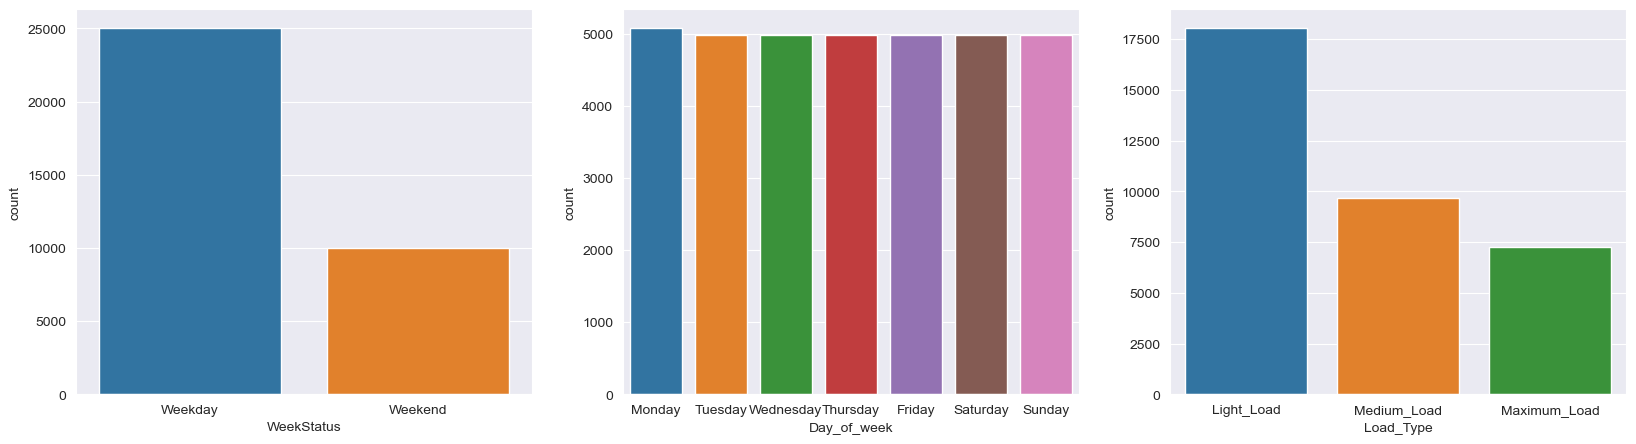

In [11]:
_, ax = plt.subplots(1, 3, figsize=(20, 5))

j = 0
for column in cat_columns:
    sns.countplot(data=data, x=column, ax=ax[j])

    j += 1

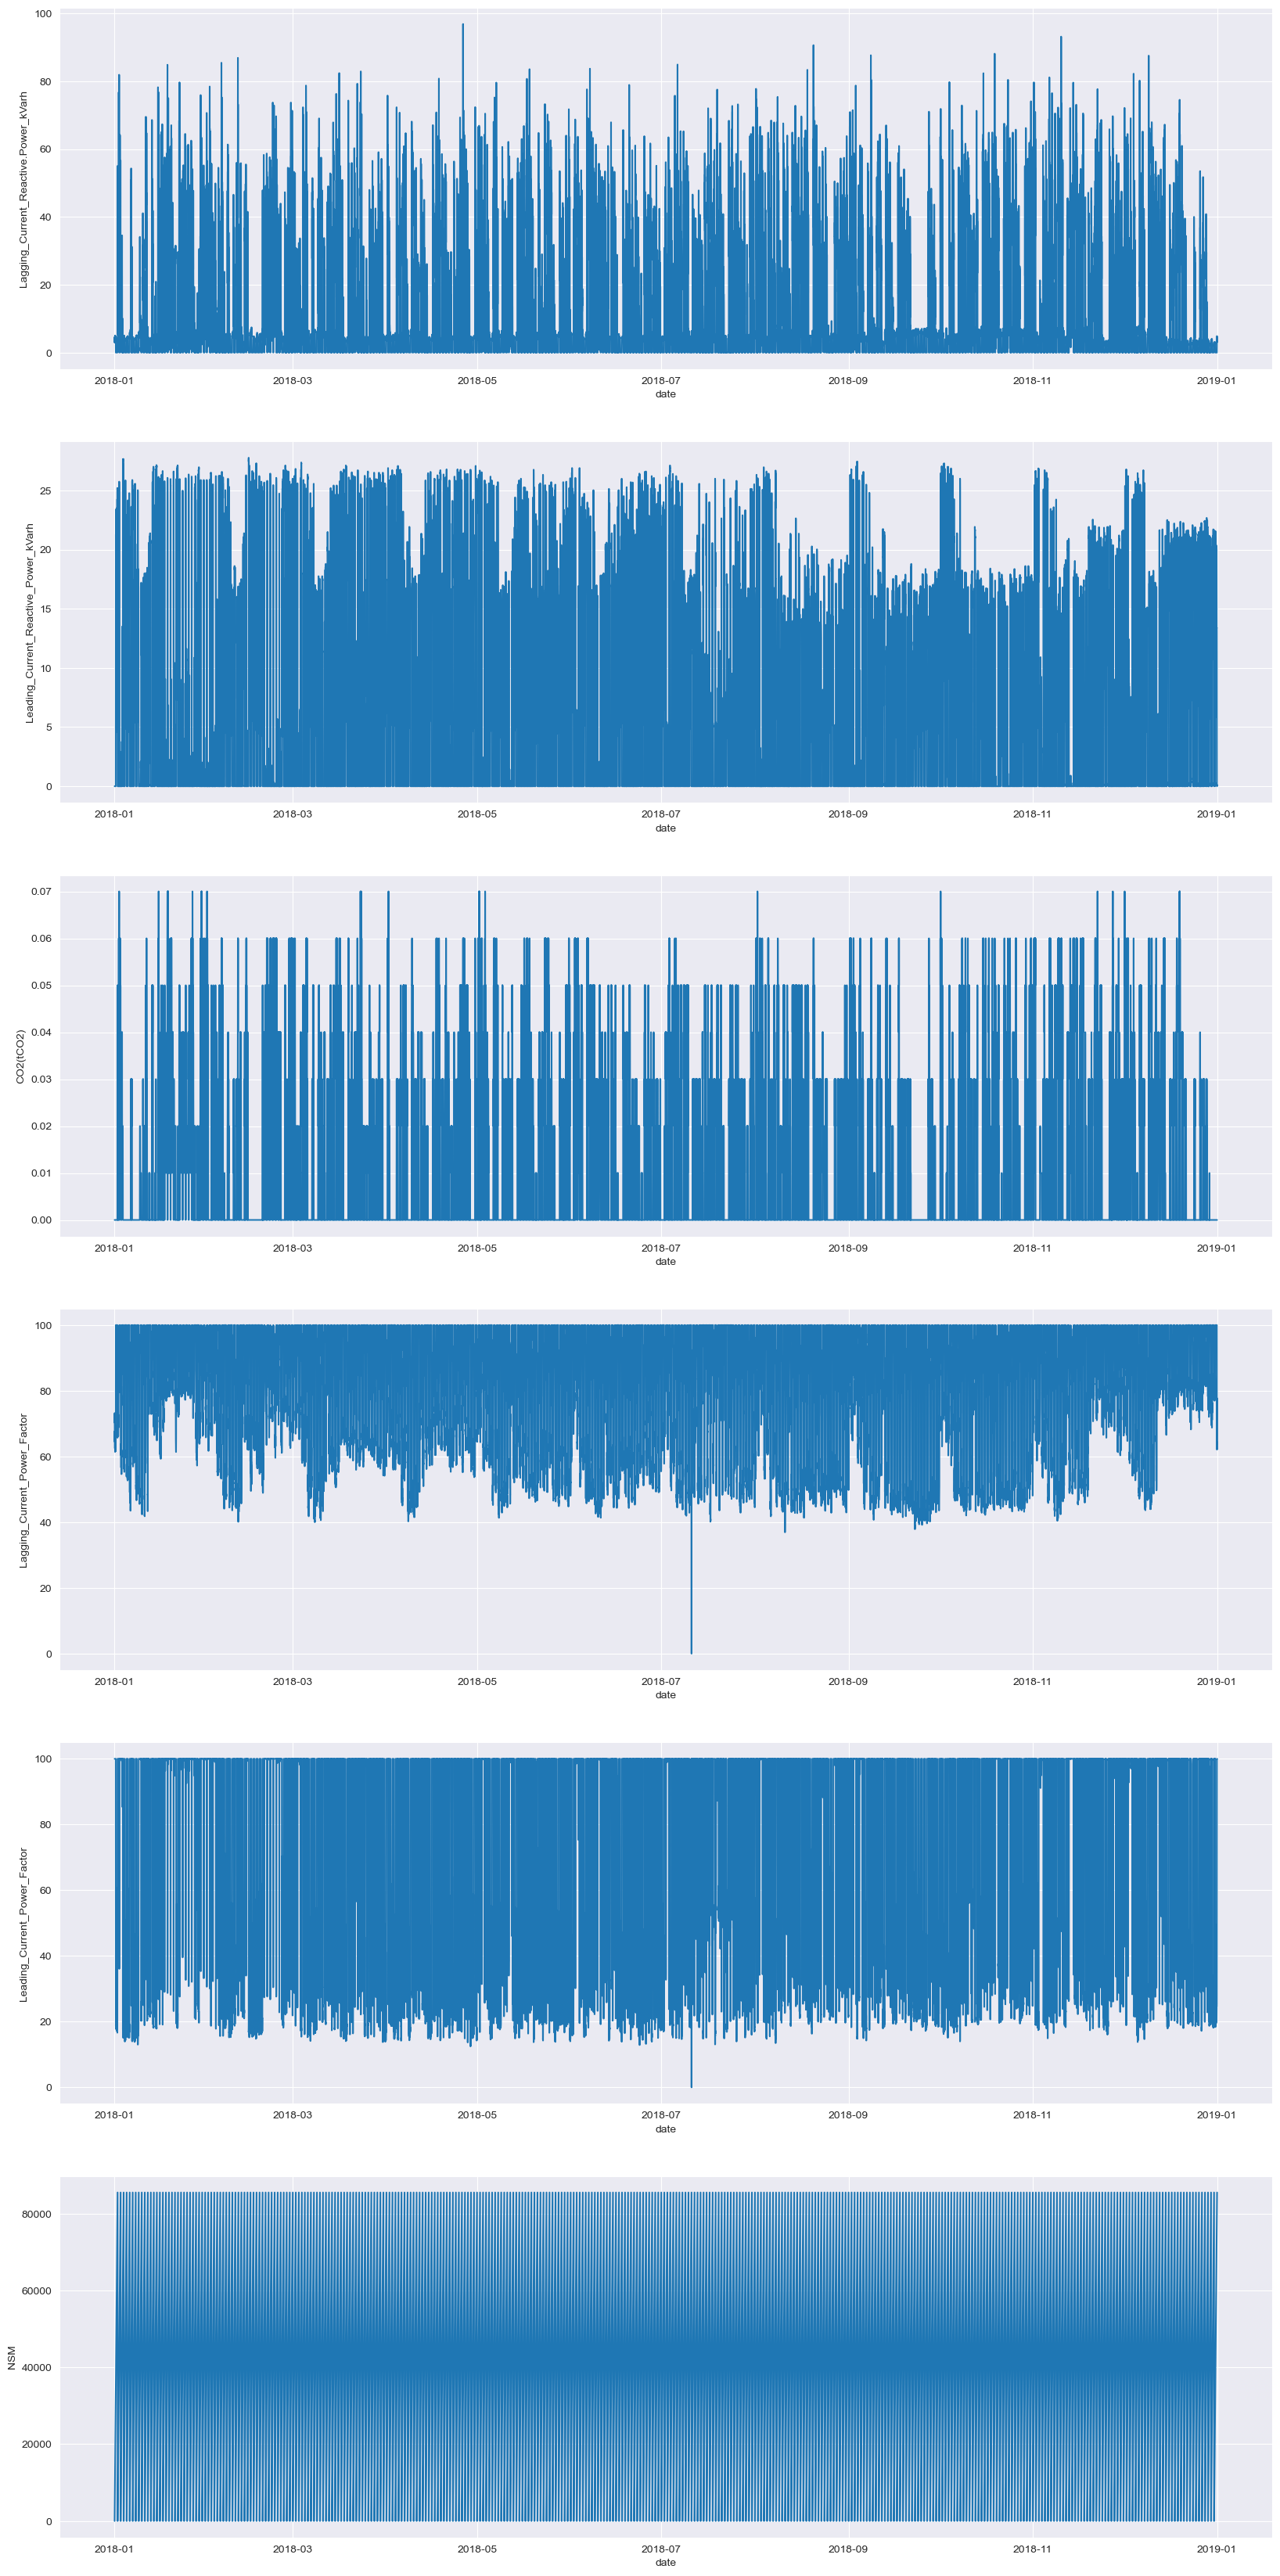

In [12]:
_, ax = plt.subplots(len(numeric_columns), 1, figsize=(20, len(numeric_columns) * 7))

j = 0
for column in numeric_columns:
    sns.lineplot(data=data, y=column, ax=ax[j], x=data.index)
    j += 1

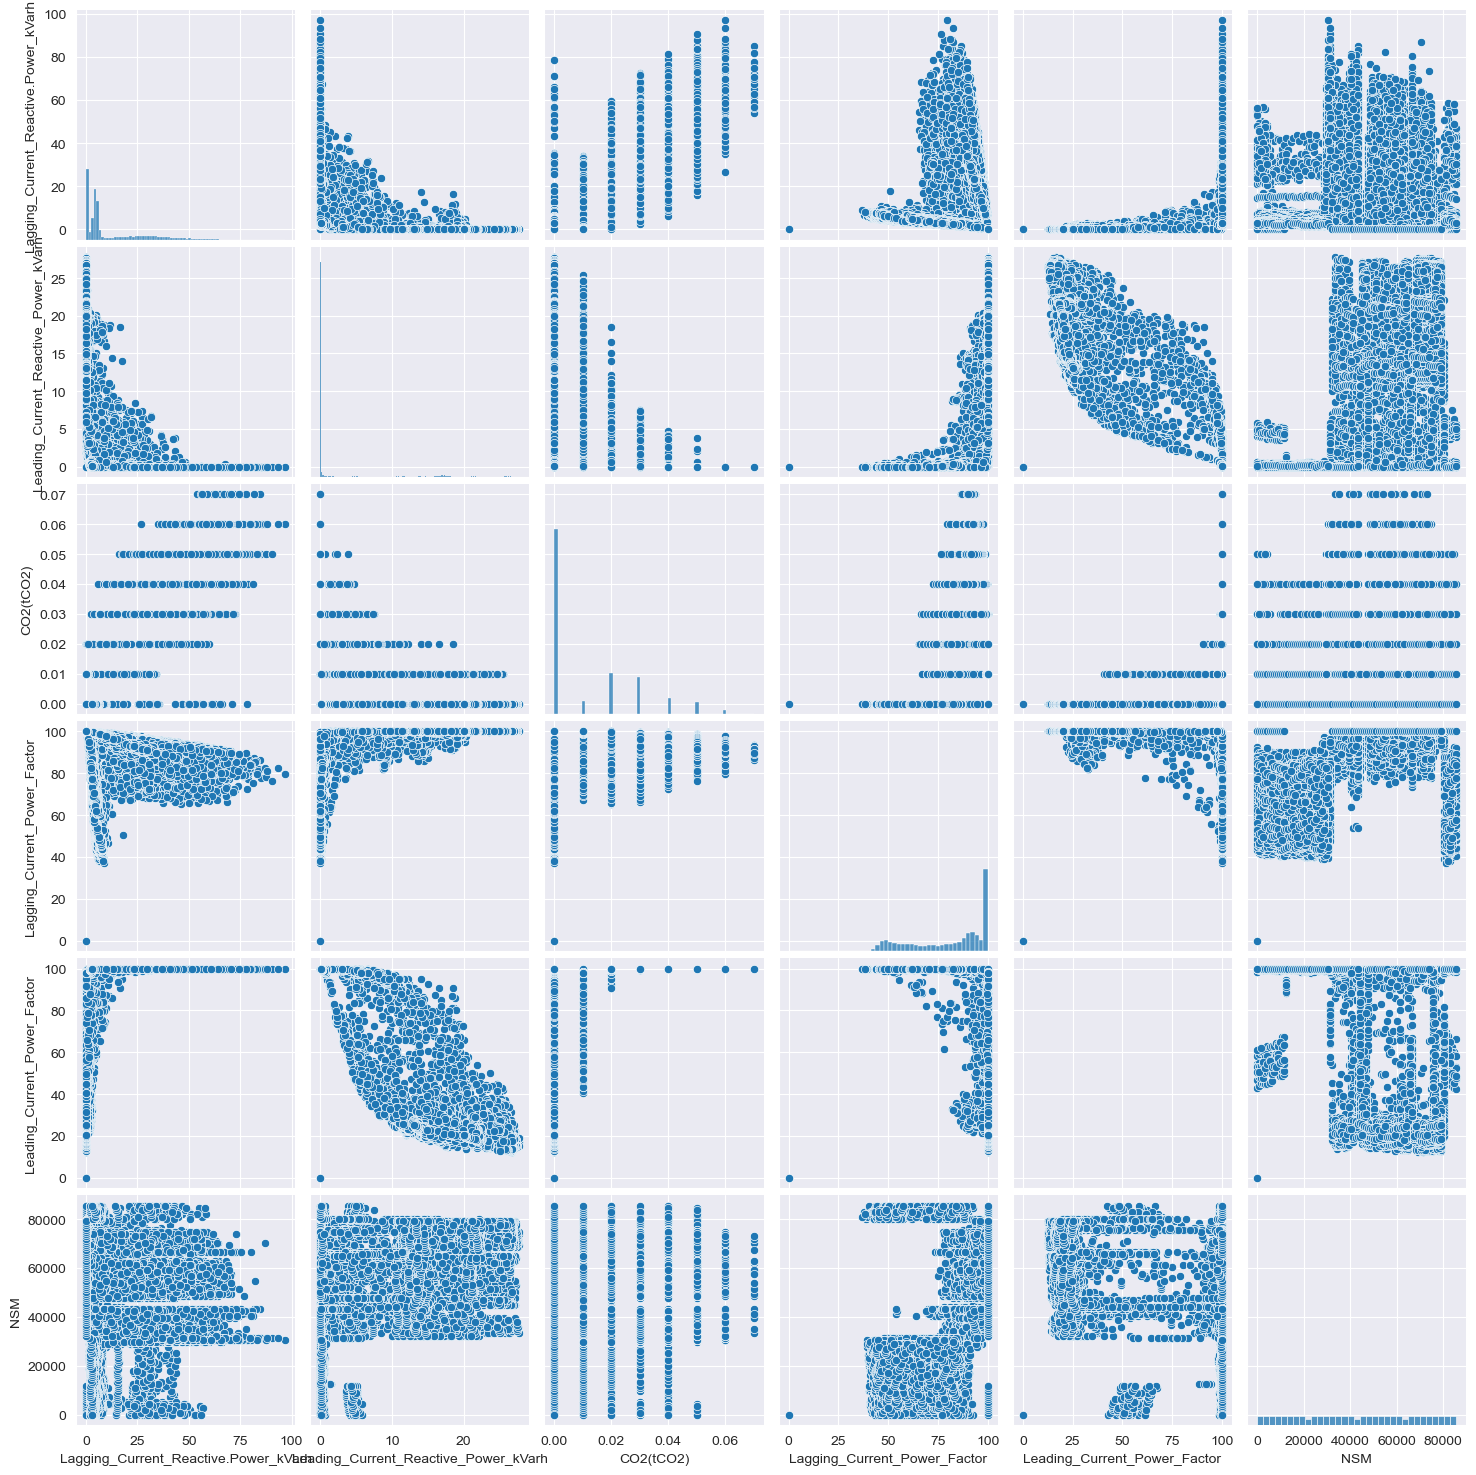

In [13]:
sns.pairplot(data[numeric_columns])

In [14]:
le = LabelEncoder()

for column in cat_columns:
    data[column] = le.fit_transform(data[column])

In [15]:
data

,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus,Day_of_week,Load_Type
date,,,,,,,,,,
2018-01-01 00:15:00,3.17,2.95,0.00,0.0,73.21,100.00,900,0,1,0
2018-01-01 00:30:00,4.00,4.46,0.00,0.0,66.77,100.00,1800,0,1,0
2018-01-01 00:45:00,3.24,3.28,0.00,0.0,70.28,100.00,2700,0,1,0
2018-01-01 01:00:00,3.31,3.56,0.00,0.0,68.09,100.00,3600,0,1,0
2018-01-01 01:15:00,3.82,4.50,0.00,0.0,64.72,100.00,4500,0,1,0
...,...,...,...,...,...,...,...,...,...,...
2018-12-31 23:00:00,3.85,4.86,0.00,0.0,62.10,100.00,82800,0,1,0
2018-12-31 23:15:00,3.74,3.74,0.00,0.0,70.71,100.00,83700,0,1,0
2018-12-31 23:30:00,3.78,3.17,0.07,0.0,76.62,99.98,84600,0,1,0


### Heatmap

<Axes: >

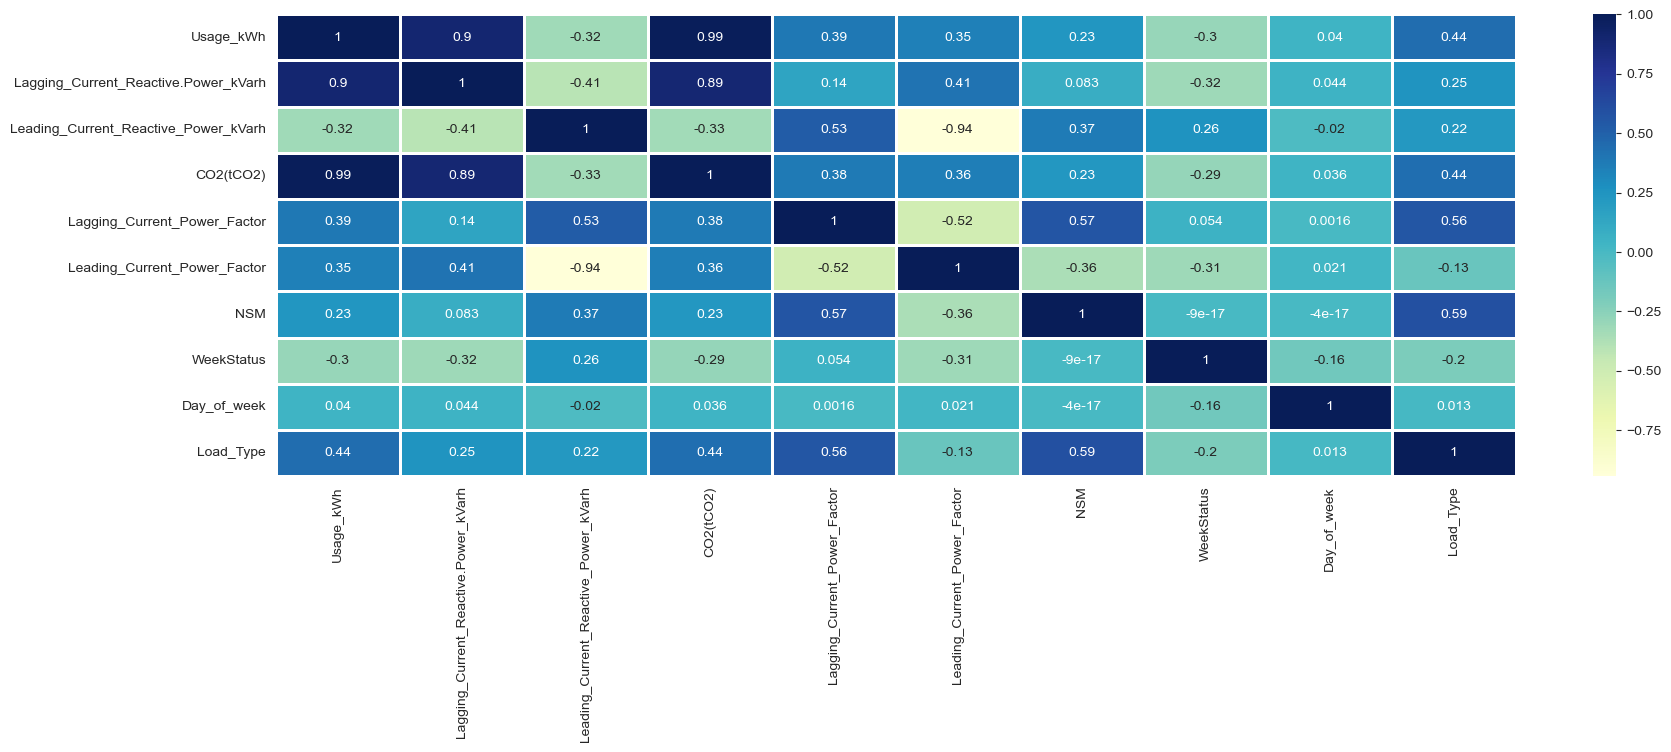

In [16]:
sns.heatmap(data.corr(), annot=True, cmap="YlGnBu", linewidths=2, cbar=True)

In [17]:
scaler = MinMaxScaler()

In [18]:
X = data.drop(['Usage_kWh'], axis=1)
Y = data['Usage_kWh']
for column in numeric_columns:
    X[column] = scaler.fit_transform(X[[column]])

In [19]:
print(X.shape, Y.shape)

(35040, 9) (35040,)


### Preparing dataset with sliding windows

In [20]:
# input sequence length
batch_size = 7

In [21]:
x = []
y = []
for i in range(data.shape[0] - batch_size):
    x.append(np.expand_dims(X[i:i + batch_size].to_numpy(), axis=2))
    y.append(np.array([[Y[i + batch_size]]]))

x = np.array(x)
y = np.array(y)

In [22]:
train_size = round(data.shape[0] * 0.7)

In [23]:
x_train, y_train = x[:train_size], y[:train_size]
x_test, y_test = x[train_size:], y[train_size:]

In [24]:
print(f'Train: {x_train.shape}, {y_train.shape}')
print(f'Test: {x_test.shape}, {y_test.shape}')

Train: (24528, 7, 9, 1), (24528, 1, 1)
Test: (10505, 7, 9, 1), (10505, 1, 1)


# Building the Network

In [25]:
RNN_network = NeuralNetwork()
RNN_network.add(RNN(input_size=9, hidden_size=13, output_size=1, random_seed=seed))

In [26]:
LSTM_network = NeuralNetwork()
LSTM_network.add(LSTM(input_size=9, hidden_size=13, output_size=1, random_seed=seed))

In [27]:
GRU_network = NeuralNetwork()
GRU_network.add(GRU(input_size=9, hidden_size=13, output_size=1, random_seed=seed))

## Train function

In [28]:
def train(model: NeuralNetwork, loss_function, epochs: int = 100, lr: float = 1e-3) -> tuple:
    train_losses = np.array([])
    test_losses = np.array([])

    train_dataset = list(zip(x_train, y_train))
    test_dataset = list(zip(x_test, y_test))

    for epoch in range(epochs):
        train_loss_value, test_loss_value = 0, 0

        # Train
        rng.shuffle(train_dataset)
        for _, (X_curr, y_curr) in enumerate(tqdm(train_dataset)):
            y_pred = model.feedforward(X_curr)
            train_loss_value += loss_function.fn(y_curr, y_pred)

            delta = loss_function.dfn(y_curr, y_pred)
            model.backprop(delta, lr)

        # Test
        for X_curr, y_curr in tqdm(test_dataset):
            y_pred = model.feedforward(X_curr)
            test_loss_value += loss_function.fn(y_curr, y_pred)

        train_loss_value /= x_train.shape[0]
        test_loss_value /= x_test.shape[0]

        train_losses = np.append(train_losses, train_loss_value)
        test_losses = np.append(test_losses, test_loss_value)

    return train_losses, test_losses

## Predict function

In [29]:
def predict(model: NeuralNetwork, X: np.ndarray) -> np.ndarray:
    y_preds = []
    for i in tqdm(range(X.shape[0])):
        y_preds.append(model.feedforward(X[i]))
    return np.array(y_preds)

# Training models

In [30]:
loss = MSE()

In [31]:
RNN_train_history, RNN_test_history = train(model=RNN_network, loss_function=loss, epochs=7, lr=1e-2)

100%|██████████| 10505/10505 [00:01<00:00, 9253.92it/s]


First train epoch loss - 1372.8179278353175
Last train epoch loss - 1370.1082585491222
First test epoch loss - 958.7276021499114
Last test epoch loss - 1043.7640165509777


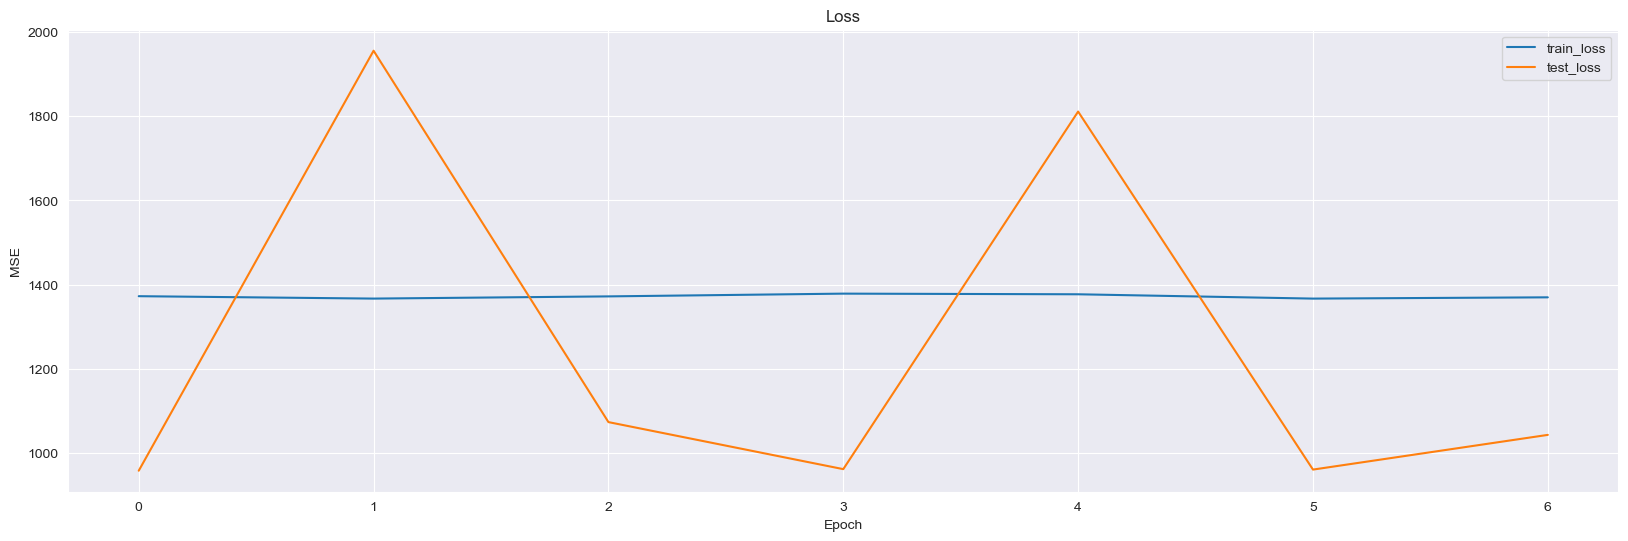

In [32]:
plt.plot(RNN_train_history, label="train_loss")
plt.plot(RNN_test_history, label="test_loss")
plt.legend()
plt.title("Loss")
plt.xlabel('Epoch')
plt.ylabel('MSE')
print(f"First train epoch loss - {RNN_train_history[0]}\nLast train epoch loss - {RNN_train_history[-1]}")
print(f"First test epoch loss - {RNN_test_history[0]}\nLast test epoch loss - {RNN_test_history[-1]}")

In [33]:
LSTM_train_history, LSTM_test_history = train(model=LSTM_network, loss_function=loss, epochs=5, lr=1e-3)

100%|██████████| 10505/10505 [00:06<00:00, 1671.30it/s]


First train epoch loss - 361.6861364953479
Last train epoch loss - 302.0231966095973
First test epoch loss - 245.5161031781207
Last test epoch loss - 180.55462008784028


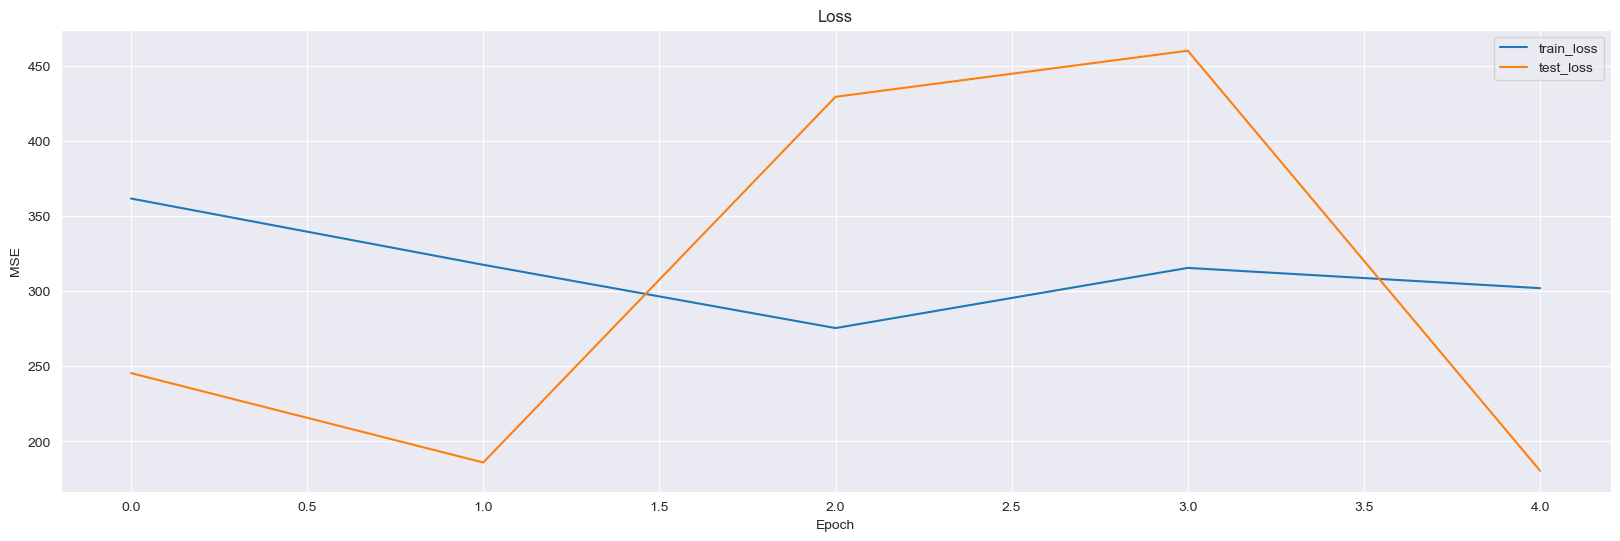

In [34]:
plt.plot(LSTM_train_history, label="train_loss")
plt.plot(LSTM_test_history, label="test_loss")
plt.legend()
plt.title("Loss")
plt.xlabel('Epoch')
plt.ylabel('MSE')
print(f"First train epoch loss - {LSTM_train_history[0]}\nLast train epoch loss - {LSTM_train_history[-1]}")
print(f"First test epoch loss - {LSTM_test_history[0]}\nLast test epoch loss - {LSTM_test_history[-1]}")

In [35]:
GRU_train_history, GRU_test_history = train(model=GRU_network, loss_function=loss, epochs=10, lr=1e-3)

100%|██████████| 10505/10505 [00:03<00:00, 2693.84it/s]


First train epoch loss - 741.632054093621
Last train epoch loss - 434.4846806313729
First test epoch loss - 349.22275823732116
Last test epoch loss - 258.00733607184793


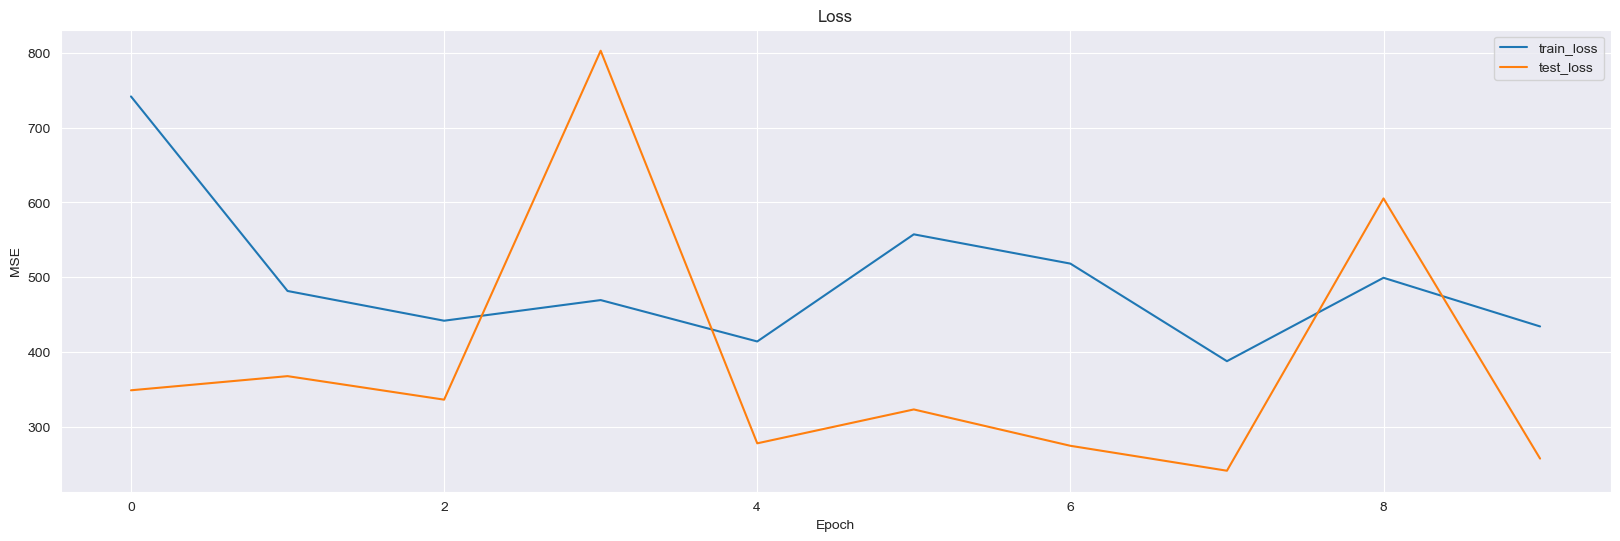

In [36]:
plt.plot(GRU_train_history, label="train_loss")
plt.plot(GRU_test_history, label="test_loss")
plt.legend()
plt.title("Loss")
plt.xlabel('Epoch')
plt.ylabel('MSE')
print(f"First train epoch loss - {GRU_train_history[0]}\nLast train epoch loss - {GRU_train_history[-1]}")
print(f"First test epoch loss - {GRU_test_history[0]}\nLast test epoch loss - {GRU_test_history[-1]}")

In [37]:
y_test = y_test.reshape(-1, 1)

In [38]:
RNN_preds = predict(model=RNN_network, X=x_test).reshape(-1, 1)
LSTM_preds = predict(model=LSTM_network, X=x_test).reshape(-1, 1)
GRU_preds = predict(model=GRU_network, X=x_test).reshape(-1, 1)

100%|██████████| 10505/10505 [00:03<00:00, 2830.69it/s]


In [39]:
RNN_mse_score = mean_squared_error(y_test, RNN_preds)
RNN_rmse_score = sqrt(RNN_mse_score)
RNN_r2 = r2_score(y_test, RNN_preds)

print(f'''
MSE: {RNN_mse_score}
RMSE: {RNN_rmse_score}
R2: {RNN_r2}
''')


MSE: 1043.7640165509686
RMSE: 32.30733688422753
R2: -0.09242446358415357



In [40]:
LSTM_mse_score = mean_squared_error(y_test, LSTM_preds)
LSTM_rmse_score = sqrt(LSTM_mse_score)
LSTM_r2 = r2_score(y_test, LSTM_preds)

print(f'''
MSE: {LSTM_mse_score}
RMSE: {LSTM_rmse_score}
R2: {LSTM_r2}
''')


MSE: 180.5546200878396
RMSE: 13.437061437972202
R2: 0.811027894361726



In [41]:
GRU_mse_score = mean_squared_error(y_test, GRU_preds)
GRU_rmse_score = sqrt(GRU_mse_score)
GRU_r2 = r2_score(y_test, GRU_preds)

print(f'''
MSE: {GRU_mse_score}
RMSE: {GRU_rmse_score}
R2: {GRU_r2}
''')


MSE: 258.00733607184765
RMSE: 16.062606764527594
R2: 0.729964320248914



### Plot the data

In [42]:
rand_index = np.random.randint(0, x_test.shape[0] - 300)

In [43]:
rand_index

2911

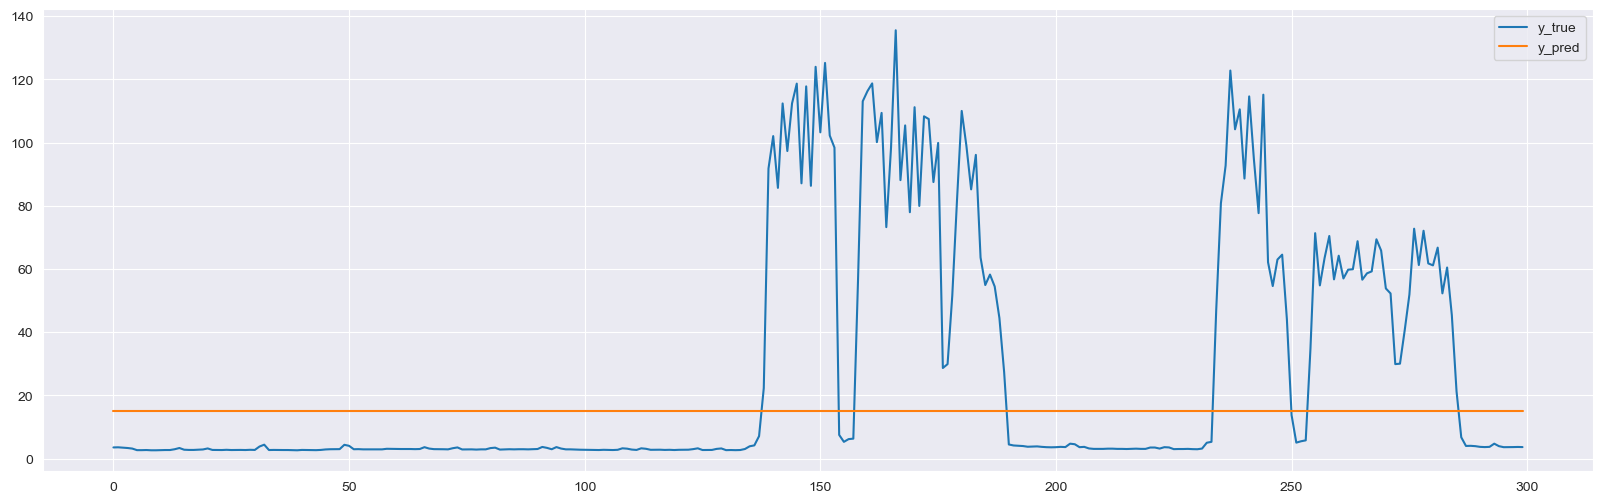

In [44]:
plt.plot(y_test[rand_index:rand_index + 300], label='y_true')
plt.plot(RNN_preds[rand_index:rand_index + 300], label='y_pred')
plt.legend()
plt.show()

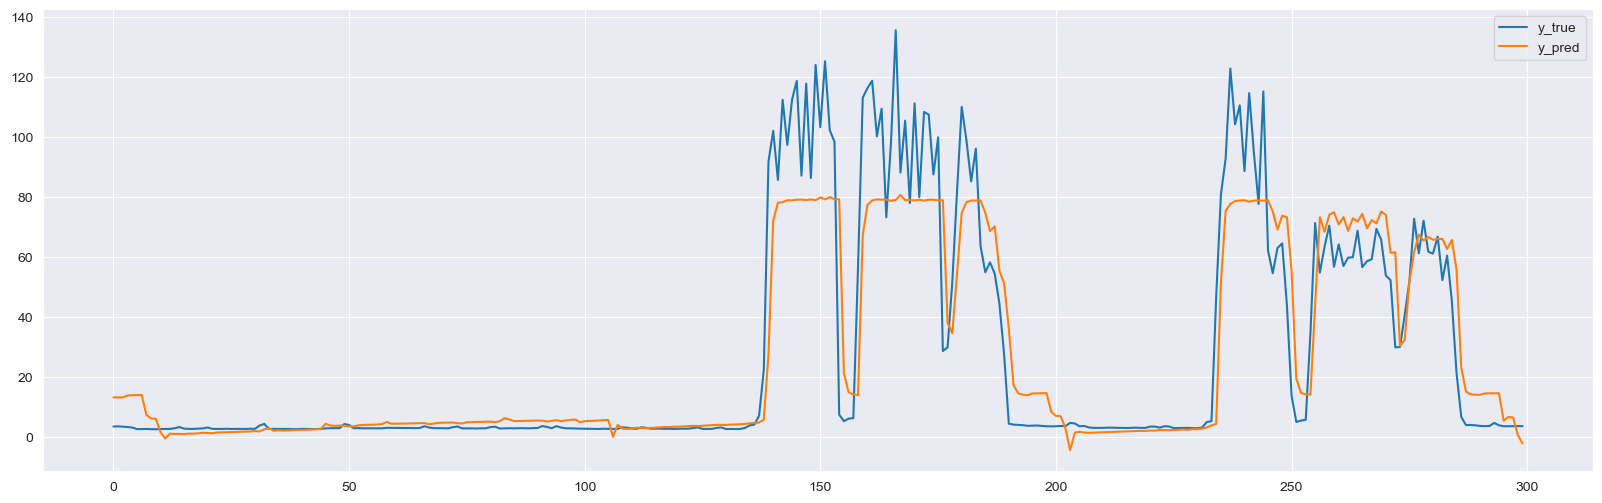

In [45]:
plt.plot(y_test[rand_index:rand_index + 300], label='y_true')
plt.plot(LSTM_preds[rand_index:rand_index + 300], label='y_pred')
plt.legend()
plt.show()

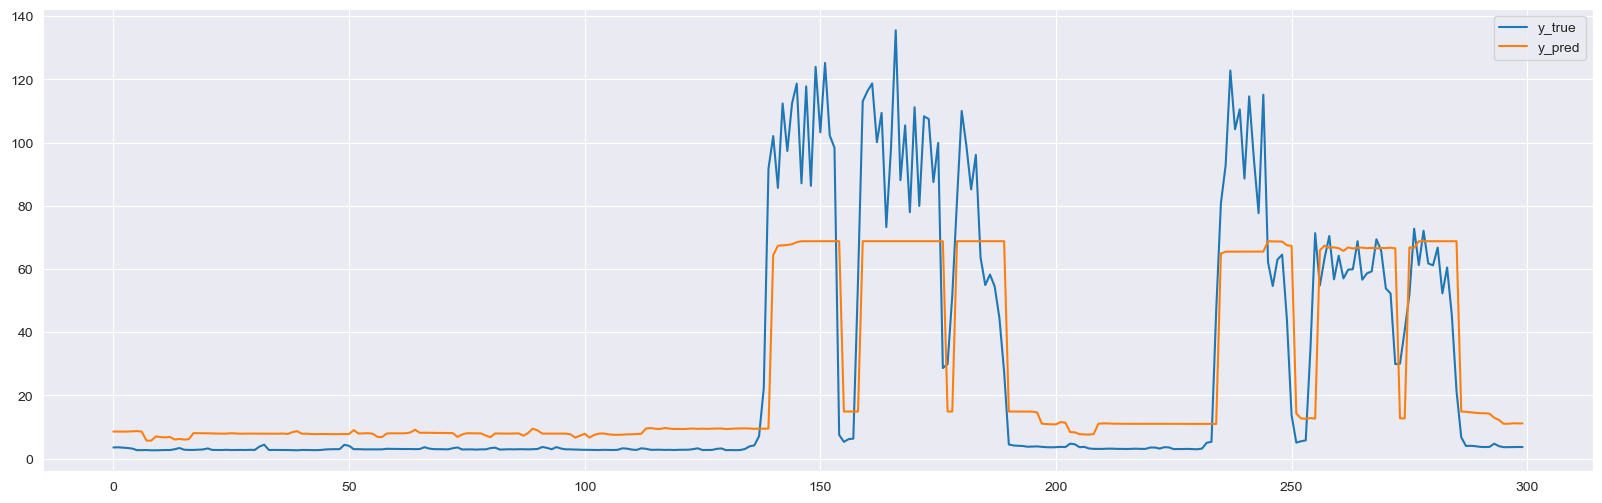

In [46]:
plt.plot(y_test[rand_index:rand_index + 300], label='y_true')
plt.plot(GRU_preds[rand_index:rand_index + 300], label='y_pred')
plt.legend()
plt.show()

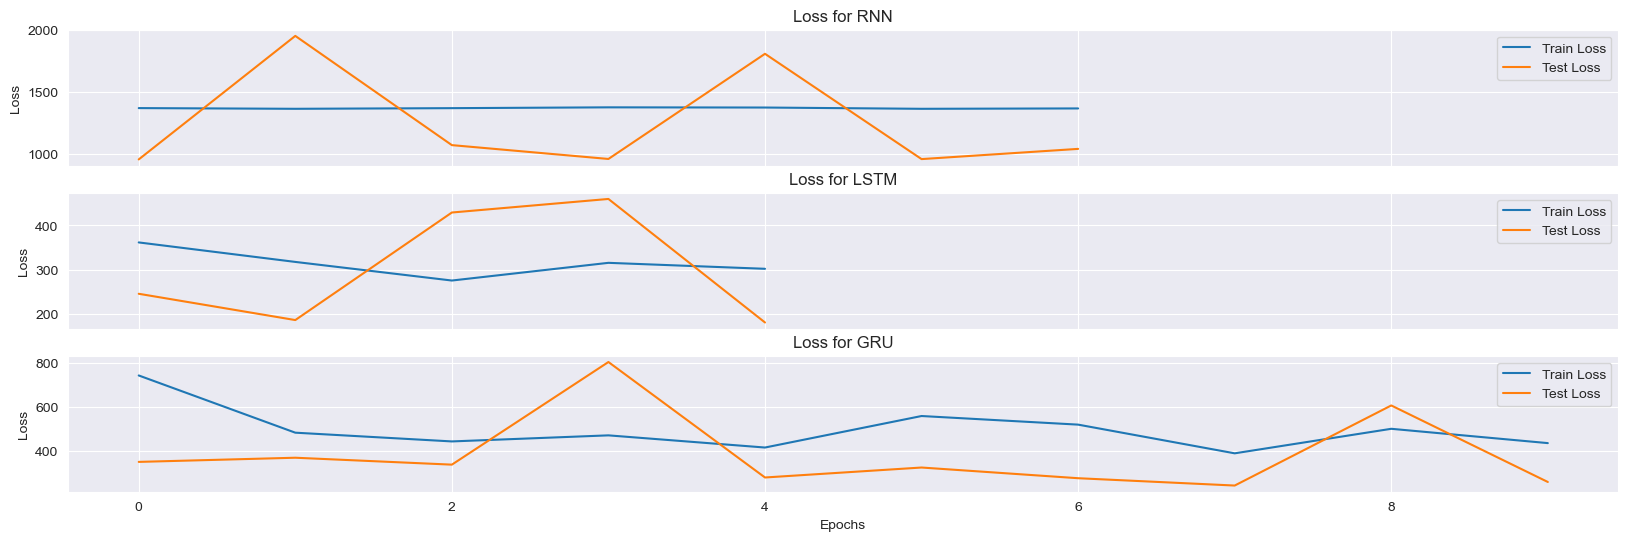

In [47]:
fig, axs = plt.subplots(3, 1, sharex=True)

axs[0].plot(RNN_train_history, label='Train Loss')
axs[0].plot(RNN_test_history, label='Test Loss')
axs[1].plot(LSTM_train_history, label='Train Loss')
axs[1].plot(LSTM_test_history, label='Test Loss')
axs[2].plot(GRU_train_history, label='Train Loss')
axs[2].plot(GRU_test_history, label='Test Loss')

axs[0].set_title('Loss for RNN')
axs[1].set_title('Loss for LSTM')
axs[2].set_title('Loss for GRU')
axs[2].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[1].set_ylabel('Loss')
axs[2].set_ylabel('Loss')

axs[0].legend()
axs[1].legend()
axs[2].legend()